In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime as dt

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [9]:
# !pip install pandas_datareader
# !pip install --upgrade pandas pandas_datareader
# !pip install yfinance

In [130]:
# Define the ticker symbol
tickerSymbol = 'MSFT'
days_period = 300

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

start_date = dt.datetime.today() - dt.timedelta(days=days_period)
end_date = dt.datetime.today()

df_all = tickerData.history(start=start_date, end=end_date, interval='1h')
df_all = df_all.drop(columns=['Dividends', 'Stock Splits', 'Volume'])

# Print the first few rows of the fetched data
# print(df_all.columns)
# df_all
# df_all.shape
df_all.tail(20)
# df = df_all
# df

,Open,High,Low,Close
Datetime,,,,
2024-04-25 10:30:00-04:00,394.070007,394.399902,390.399994,392.399200
2024-04-25 11:30:00-04:00,392.390015,394.779999,391.799988,394.450012
2024-04-25 12:30:00-04:00,394.450012,396.565002,394.250000,395.929993
2024-04-25 13:30:00-04:00,395.910004,399.688507,395.760010,397.230011
2024-04-25 14:30:00-04:00,397.234985,399.209991,396.019989,399.209991
2024-04-25 15:30:00-04:00,399.214996,399.889893,397.989990,399.510010
2024-04-26 09:30:00-04:00,412.410004,413.000000,405.760101,409.910004
2024-04-26 10:30:00-04:00,409.904999,412.089996,408.309998,408.890015
2024-04-26 11:30:00-04:00,408.890015,410.109985,408.329987,408.679993


In [131]:
df = df_all

df = df.iloc[:-1]

# Assuming df is your DataFrame with the correct datetime index
df.index = pd.to_datetime(df.index)  # Ensure datetime format

# Define the trading hours
trading_start = '09:30:00'
trading_end = '16:00:00'

# Normalize the timezone if necessary, here assuming the data might be timezone aware
df.index = df.index.tz_localize(None)

# Find the latest date in your data
latest_date = df.index.max().date()

# Generate a full range of expected trading hours for the latest date, ensuring it's timezone-naive
expected_hours = pd.date_range(start=f'{latest_date} {trading_start}', end=f'{latest_date} {trading_end}', freq='H', tz=None)

# Extract actual timestamps for the latest date, also as timezone-naive
actual_hours = df[df.index.date == latest_date].index.tz_localize(None)

# Determine missing hours
missing_hours = expected_hours.difference(actual_hours)

print("Missing trading hours on the latest date:", missing_hours)


Missing trading hours on the latest date: DatetimeIndex(['2024-04-29 15:30:00'], dtype='datetime64[ns]', freq='h')


C:\Users\Yefet\AppData\Local\Temp\ipykernel_13768\1848918443.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  expected_hours = pd.date_range(start=f'{latest_date} {trading_start}', end=f'{latest_date} {trading_end}', freq='H', tz=None)


In [132]:
# Add missing hours to the DataFrame as empty rows
for hour in missing_hours:
    if hour not in df.index:
        df.loc[hour] = [pd.NA] * len(df.columns)  # Initialize missing hours with NA

# Sort the DataFrame after inserting new rows to maintain the chronological order
df.sort_index(inplace=True)
df

C:\Users\Yefet\AppData\Local\Temp\ipykernel_13768\241812315.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[hour] = [pd.NA] * len(df.columns)  # Initialize missing hours with NA


,Open,High,Low,Close
Datetime,,,,
2023-07-05 09:30:00,335.089996,340.708588,334.727600,340.429993
2023-07-05 10:30:00,340.440002,341.649994,338.720001,338.730011
2023-07-05 11:30:00,338.730011,339.355011,338.579987,339.139893
2023-07-05 12:30:00,339.140015,339.200012,338.170013,338.566406
2023-07-05 13:30:00,338.549988,338.799988,337.640015,338.029999
...,...,...,...,...
2024-04-29 11:30:00,400.470001,401.369995,400.103485,401.200012
2024-04-29 12:30:00,401.200012,401.679596,400.630005,401.029999
2024-04-29 13:30:00,401.019989,402.160004,400.899994,401.110291


In [133]:
# Ensure the index is in datetime format and normalized
df.index = pd.to_datetime(df.index)
df.index = df.index.tz_localize(None)

# Find the latest date in your data
latest_date = df.index.max().date()

# Select only the data for the latest day
latest_day_data = df[df.index.date == latest_date]

# Perform forward filling on this latest day data
latest_day_data_filled = latest_day_data.ffill()

# Replace the original latest day data in the DataFrame with the filled data
df.loc[df.index.date == latest_date] = latest_day_data_filled

# Optionally, ensure the entire DataFrame is sorted by index
df.sort_index(inplace=True)
df

,Open,High,Low,Close
Datetime,,,,
2023-07-05 09:30:00,335.089996,340.708588,334.727600,340.429993
2023-07-05 10:30:00,340.440002,341.649994,338.720001,338.730011
2023-07-05 11:30:00,338.730011,339.355011,338.579987,339.139893
2023-07-05 12:30:00,339.140015,339.200012,338.170013,338.566406
2023-07-05 13:30:00,338.549988,338.799988,337.640015,338.029999
...,...,...,...,...
2024-04-29 11:30:00,400.470001,401.369995,400.103485,401.200012
2024-04-29 12:30:00,401.200012,401.679596,400.630005,401.029999
2024-04-29 13:30:00,401.019989,402.160004,400.899994,401.110291


In [134]:
# Assuming 'df' is your initial DataFrame
df.index = pd.to_datetime(df.index)  # Ensure the index is datetime

# Extract date and time from the datetime index
df['Date'] = df.index.date
df['Time'] = df.index.time

# Filter out data for hours from 09:30 to 14:30 and the target at 15:30
df_hours = df[df['Time'].isin([pd.to_datetime('09:30:00').time(),
                               pd.to_datetime('10:30:00').time(),
                               pd.to_datetime('11:30:00').time(),
                               pd.to_datetime('12:30:00').time(),
                               pd.to_datetime('13:30:00').time(),
                               pd.to_datetime('14:30:00').time()])]
df_target = df[df['Time'] == pd.to_datetime('15:30:00').time()][['Date', 'Close']]

# Rename the target close column for clarity
df_target.rename(columns={'Close': 'Close_target'}, inplace=True)

# Pivot the hours data to have one row per day with all the columns
df_pivot = df_hours.pivot(index='Date', columns='Time', values=['Open', 'High', 'Low', 'Close'])

# Flatten the columns after pivoting and create a multi-level index
df_pivot.columns = ['{}_{}'.format(feature, time.strftime('%H:%M')) for feature, time in df_pivot.columns]

# Join the pivot table with the target data
df_final = df_pivot.join(df_target.set_index('Date'))

# Convert the index back to datetime if it got changed to object type
df_final.index = pd.to_datetime(df_final.index)

pd.set_option('display.max_columns', 100)
df_final

,Open_09:30,Open_10:30,Open_11:30,Open_12:30,Open_13:30,Open_14:30,High_09:30,High_10:30,High_11:30,High_12:30,High_13:30,High_14:30,Low_09:30,Low_10:30,Low_11:30,Low_12:30,Low_13:30,Low_14:30,Close_09:30,Close_10:30,Close_11:30,Close_12:30,Close_13:30,Close_14:30,Close_target
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2023-07-05,335.089996,340.440002,338.730011,339.140015,338.549988,338.059998,340.708588,341.649994,339.355011,339.200012,338.799988,338.750000,334.727600,338.720001,338.579987,338.170013,337.640015,338.000000,340.429993,338.730011,339.139893,338.566406,338.029999,338.369995,338.160004
2023-07-06,337.299988,340.579987,338.720001,341.589996,342.045013,340.920013,340.649994,341.119995,341.660004,342.989990,342.500000,341.589996,335.500000,338.089996,338.420013,341.404999,340.899994,340.690002,340.609711,338.700012,341.619995,342.029999,340.940002,341.299988,341.269989
2023-07-07,339.320007,338.549988,339.059998,340.279999,341.719208,340.070007,341.200012,339.529999,340.559998,341.670013,341.790009,340.260010,338.559998,337.559998,338.619995,340.279999,339.690002,338.420013,338.559998,339.059998,340.290009,341.670013,340.089996,338.584991,337.190002
2023-07-10,334.600006,331.920013,330.279999,329.255005,330.880005,331.429993,335.230011,332.010010,331.119995,330.880005,331.670013,331.559998,329.230011,329.679993,327.589996,329.029999,329.480011,330.220001,331.940002,330.269989,329.259888,330.880005,331.429993,330.549988,331.859985
2023-07-11,331.059998,328.790009,329.739990,330.470001,331.040009,330.750000,331.450012,330.790009,332.859985,331.559998,332.049988,331.850006,327.000000,328.779999,329.330994,330.350006,330.549988,330.130005,328.815002,329.730011,330.450012,331.029999,330.730011,331.279999,332.470001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-23,404.250000,407.429993,406.600006,407.390015,407.000000,407.475006,407.799988,408.200012,407.672089,407.470001,407.891998,407.629913,403.059998,405.839996,406.179993,406.200012,406.950012,406.570007,407.399994,406.579987,407.399994,407.039398,407.475006,407.029999,407.480988
2024-04-24,409.559998,408.890015,408.179993,407.570007,408.760010,408.640015,412.459991,409.644989,408.619995,408.790009,410.119995,409.499390,408.700012,408.070007,406.880005,406.779999,408.470001,407.540009,408.890015,408.109985,407.619995,408.709991,408.630005,409.089996,408.859985
2024-04-25,394.089996,394.070007,392.390015,394.450012,395.910004,397.234985,395.000000,394.399902,394.779999,396.565002,399.688507,399.209991,388.035492,390.399994,391.799988,394.250000,395.760010,396.019989,394.105011,392.399200,394.450012,395.929993,397.230011,399.209991,399.510010


In [135]:
# Extract columns for 'High' and 'Low' values
high_columns = [col for col in df_final.columns if 'High_' in col]
low_columns = [col for col in df_final.columns if 'Low_' in col]

# Calculate 'max high' and 'min low' for each day
df_final['MAX_high'] = df_final[high_columns].max(axis=1)
df_final['MIN_low'] = df_final[low_columns].min(axis=1)

pd.set_option('display.max_columns', 100)
df_final


,Open_09:30,Open_10:30,Open_11:30,Open_12:30,Open_13:30,Open_14:30,High_09:30,High_10:30,High_11:30,High_12:30,High_13:30,High_14:30,Low_09:30,Low_10:30,Low_11:30,Low_12:30,Low_13:30,Low_14:30,Close_09:30,Close_10:30,Close_11:30,Close_12:30,Close_13:30,Close_14:30,Close_target,MAX_high,MIN_low
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-07-05,335.089996,340.440002,338.730011,339.140015,338.549988,338.059998,340.708588,341.649994,339.355011,339.200012,338.799988,338.750000,334.727600,338.720001,338.579987,338.170013,337.640015,338.000000,340.429993,338.730011,339.139893,338.566406,338.029999,338.369995,338.160004,341.649994,334.727600
2023-07-06,337.299988,340.579987,338.720001,341.589996,342.045013,340.920013,340.649994,341.119995,341.660004,342.989990,342.500000,341.589996,335.500000,338.089996,338.420013,341.404999,340.899994,340.690002,340.609711,338.700012,341.619995,342.029999,340.940002,341.299988,341.269989,342.989990,335.500000
2023-07-07,339.320007,338.549988,339.059998,340.279999,341.719208,340.070007,341.200012,339.529999,340.559998,341.670013,341.790009,340.260010,338.559998,337.559998,338.619995,340.279999,339.690002,338.420013,338.559998,339.059998,340.290009,341.670013,340.089996,338.584991,337.190002,341.790009,337.559998
2023-07-10,334.600006,331.920013,330.279999,329.255005,330.880005,331.429993,335.230011,332.010010,331.119995,330.880005,331.670013,331.559998,329.230011,329.679993,327.589996,329.029999,329.480011,330.220001,331.940002,330.269989,329.259888,330.880005,331.429993,330.549988,331.859985,335.230011,327.589996
2023-07-11,331.059998,328.790009,329.739990,330.470001,331.040009,330.750000,331.450012,330.790009,332.859985,331.559998,332.049988,331.850006,327.000000,328.779999,329.330994,330.350006,330.549988,330.130005,328.815002,329.730011,330.450012,331.029999,330.730011,331.279999,332.470001,332.859985,327.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-23,404.250000,407.429993,406.600006,407.390015,407.000000,407.475006,407.799988,408.200012,407.672089,407.470001,407.891998,407.629913,403.059998,405.839996,406.179993,406.200012,406.950012,406.570007,407.399994,406.579987,407.399994,407.039398,407.475006,407.029999,407.480988,408.200012,403.059998
2024-04-24,409.559998,408.890015,408.179993,407.570007,408.760010,408.640015,412.459991,409.644989,408.619995,408.790009,410.119995,409.499390,408.700012,408.070007,406.880005,406.779999,408.470001,407.540009,408.890015,408.109985,407.619995,408.709991,408.630005,409.089996,408.859985,412.459991,406.779999
2024-04-25,394.089996,394.070007,392.390015,394.450012,395.910004,397.234985,395.000000,394.399902,394.779999,396.565002,399.688507,399.209991,388.035492,390.399994,391.799988,394.250000,395.760010,396.019989,394.105011,392.399200,394.450012,395.929993,397.230011,399.209991,399.510010,399.688507,388.035492


In [136]:
df = df_final
df = df.dropna()
df

,Open_09:30,Open_10:30,Open_11:30,Open_12:30,Open_13:30,Open_14:30,High_09:30,High_10:30,High_11:30,High_12:30,High_13:30,High_14:30,Low_09:30,Low_10:30,Low_11:30,Low_12:30,Low_13:30,Low_14:30,Close_09:30,Close_10:30,Close_11:30,Close_12:30,Close_13:30,Close_14:30,Close_target,MAX_high,MIN_low
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-07-05,335.089996,340.440002,338.730011,339.140015,338.549988,338.059998,340.708588,341.649994,339.355011,339.200012,338.799988,338.750000,334.727600,338.720001,338.579987,338.170013,337.640015,338.000000,340.429993,338.730011,339.139893,338.566406,338.029999,338.369995,338.160004,341.649994,334.727600
2023-07-06,337.299988,340.579987,338.720001,341.589996,342.045013,340.920013,340.649994,341.119995,341.660004,342.989990,342.500000,341.589996,335.500000,338.089996,338.420013,341.404999,340.899994,340.690002,340.609711,338.700012,341.619995,342.029999,340.940002,341.299988,341.269989,342.989990,335.500000
2023-07-07,339.320007,338.549988,339.059998,340.279999,341.719208,340.070007,341.200012,339.529999,340.559998,341.670013,341.790009,340.260010,338.559998,337.559998,338.619995,340.279999,339.690002,338.420013,338.559998,339.059998,340.290009,341.670013,340.089996,338.584991,337.190002,341.790009,337.559998
2023-07-10,334.600006,331.920013,330.279999,329.255005,330.880005,331.429993,335.230011,332.010010,331.119995,330.880005,331.670013,331.559998,329.230011,329.679993,327.589996,329.029999,329.480011,330.220001,331.940002,330.269989,329.259888,330.880005,331.429993,330.549988,331.859985,335.230011,327.589996
2023-07-11,331.059998,328.790009,329.739990,330.470001,331.040009,330.750000,331.450012,330.790009,332.859985,331.559998,332.049988,331.850006,327.000000,328.779999,329.330994,330.350006,330.549988,330.130005,328.815002,329.730011,330.450012,331.029999,330.730011,331.279999,332.470001,332.859985,327.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-23,404.250000,407.429993,406.600006,407.390015,407.000000,407.475006,407.799988,408.200012,407.672089,407.470001,407.891998,407.629913,403.059998,405.839996,406.179993,406.200012,406.950012,406.570007,407.399994,406.579987,407.399994,407.039398,407.475006,407.029999,407.480988,408.200012,403.059998
2024-04-24,409.559998,408.890015,408.179993,407.570007,408.760010,408.640015,412.459991,409.644989,408.619995,408.790009,410.119995,409.499390,408.700012,408.070007,406.880005,406.779999,408.470001,407.540009,408.890015,408.109985,407.619995,408.709991,408.630005,409.089996,408.859985,412.459991,406.779999
2024-04-25,394.089996,394.070007,392.390015,394.450012,395.910004,397.234985,395.000000,394.399902,394.779999,396.565002,399.688507,399.209991,388.035492,390.399994,391.799988,394.250000,395.760010,396.019989,394.105011,392.399200,394.450012,395.929993,397.230011,399.209991,399.510010,399.688507,388.035492


In [137]:

# Convert index to datetime if necessary (if not already done)
df.index = pd.to_datetime(df.index)

# Calculate the percentage change relative to 'Open_09:30' for each column
for column in df.columns:
    if column != 'Open_09:30':
        df[column] = (df[column] - df['Open_09:30']) / df['Open_09:30'] * 100

df

C:\Users\Yefet\AppData\Local\Temp\ipykernel_13768\97982771.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = (df[column] - df['Open_09:30']) / df['Open_09:30'] * 100


,Open_09:30,Open_10:30,Open_11:30,Open_12:30,Open_13:30,Open_14:30,High_09:30,High_10:30,High_11:30,High_12:30,High_13:30,High_14:30,Low_09:30,Low_10:30,Low_11:30,Low_12:30,Low_13:30,Low_14:30,Close_09:30,Close_10:30,Close_11:30,Close_12:30,Close_13:30,Close_14:30,Close_target,MAX_high,MIN_low
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-07-05,335.089996,1.596588,1.086280,1.208636,1.032556,0.886329,1.676741,1.957682,1.272797,1.226541,1.107163,1.092245,-0.108149,1.083293,1.041508,0.919161,0.760995,0.868425,1.593601,1.086280,1.208600,1.037456,0.877377,0.978841,0.916174,1.957682,-0.108149
2023-07-06,337.299988,0.972428,0.420994,1.271867,1.406767,1.073236,0.993183,1.132525,1.292623,1.686926,1.541658,1.271867,-0.533646,0.234215,0.332056,1.217021,1.067301,1.005044,0.981240,0.415068,1.280761,1.402316,1.079162,1.185888,1.176994,1.686926,-0.533646
2023-07-07,339.320007,-0.226930,-0.076627,0.282916,0.707061,0.221030,0.554051,0.061886,0.365434,0.692563,0.727927,0.277025,-0.223980,-0.518687,-0.206299,0.282916,0.109040,-0.265235,-0.223980,-0.076627,0.285866,0.692563,0.226921,-0.216614,-0.627727,0.727927,-0.518687
2023-07-10,334.600006,-0.800954,-1.291096,-1.597430,-1.111776,-0.947404,0.188286,-0.774057,-1.040051,-1.111776,-0.875670,-0.908550,-1.604900,-1.470416,-2.095042,-1.664676,-1.530184,-1.309027,-0.794980,-1.294088,-1.595971,-1.111776,-0.947404,-1.210406,-0.818894,0.188286,-2.095042
2023-07-11,331.059998,-0.685673,-0.398721,-0.178214,-0.006038,-0.093638,0.117808,-0.081553,0.543704,0.151030,0.299037,0.238630,-1.226363,-0.688697,-0.522263,-0.214460,-0.154054,-0.280914,-0.678123,-0.401736,-0.184252,-0.009061,-0.099676,0.066454,0.425906,0.543704,-1.226363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-23,404.250000,0.786640,0.581325,0.776751,0.680272,0.797775,0.878166,0.977121,0.846528,0.796537,0.900927,0.836095,-0.294373,0.393320,0.477426,0.482378,0.667907,0.573904,0.779219,0.576373,0.779219,0.690018,0.797775,0.687693,0.799255,0.977121,-0.294373
2024-04-24,409.559998,-0.163586,-0.336948,-0.485885,-0.195329,-0.224627,0.708075,0.020752,-0.229515,-0.188004,0.136732,-0.014798,-0.209978,-0.363803,-0.654359,-0.678777,-0.266138,-0.493210,-0.163586,-0.354041,-0.473680,-0.207541,-0.227071,-0.114758,-0.170918,0.708075,-0.678777
2024-04-25,394.089996,-0.005072,-0.431369,0.091354,0.461825,0.798038,0.230913,0.078638,0.175088,0.628031,1.420617,1.299194,-1.536325,-0.936335,-0.581088,0.040601,0.423764,0.489734,0.003810,-0.429038,0.091354,0.466897,0.796776,1.299194,1.375324,1.420617,-1.536325


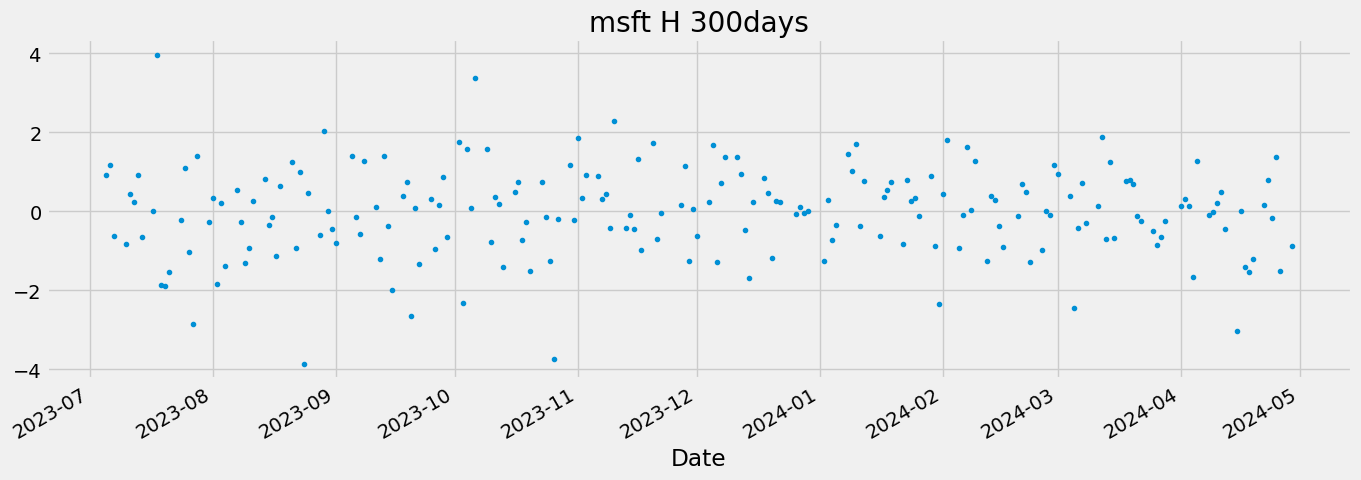

In [138]:
df['Close_target'].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title= f'msft H {days_period}days')
plt.show()

#### Train / Test SPLIT

In [42]:
# df.dtypes

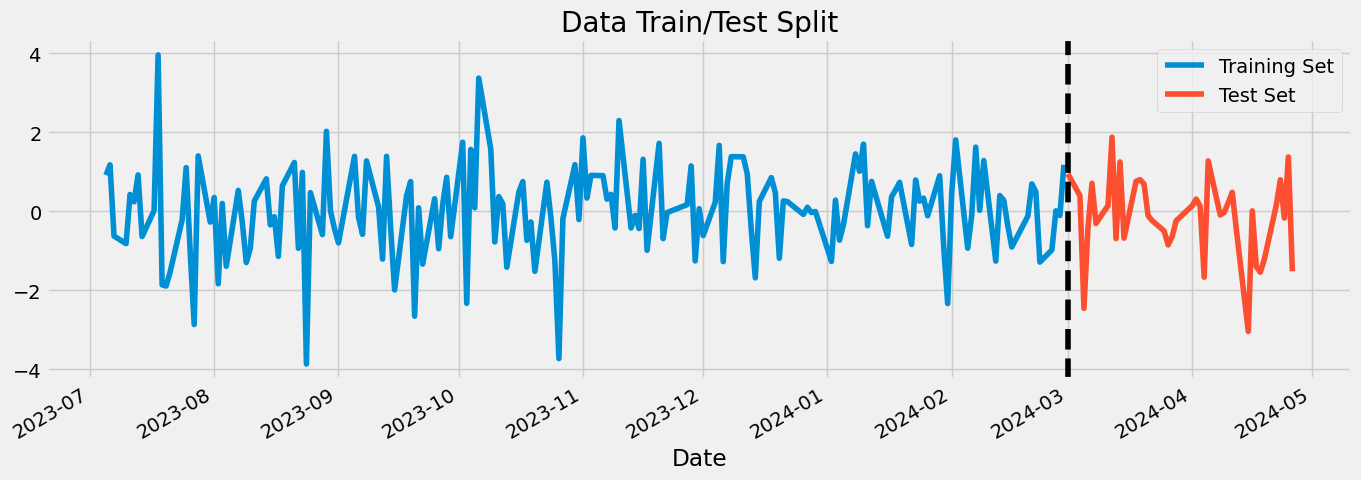

In [87]:
train = df.loc[df.index < '03-01-2024']
test = df.loc[df.index >= '03-01-2024']


fig, ax = plt.subplots(figsize=(15, 5))
train['Close_target'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['Close_target'].plot(ax=ax, label='Test Set')
ax.axvline('03-01-2024', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

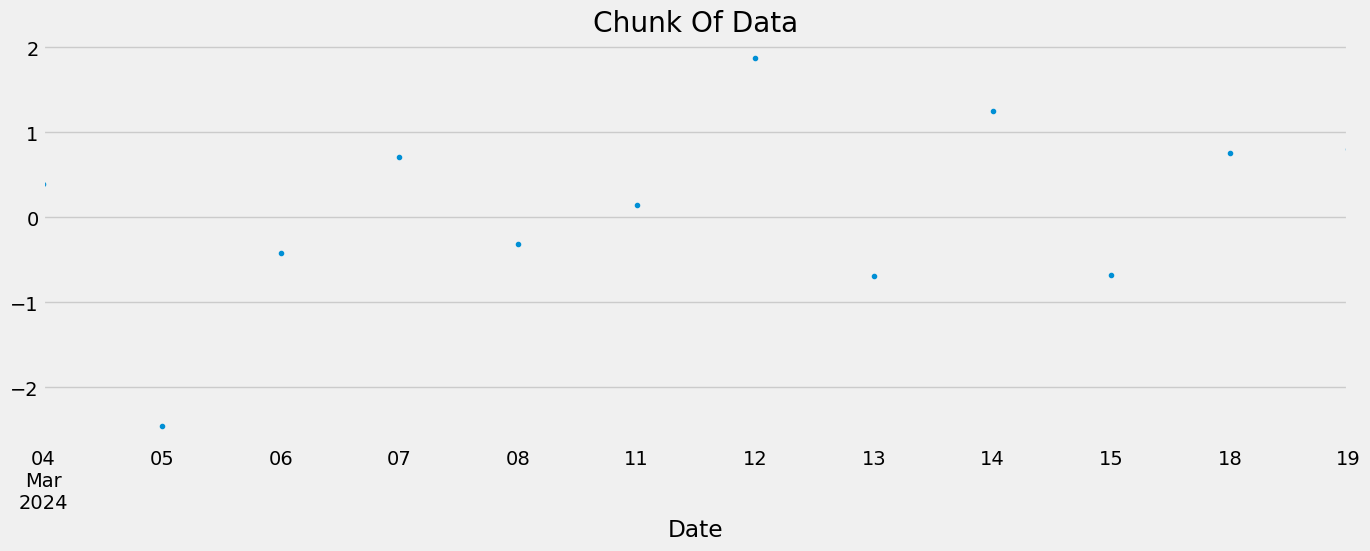

In [88]:
df['Close_target'].loc[(df.index > '03-01-2024') & (df.index < '03-20-2024')] \
    .plot(style='.',figsize=(15, 5), title='Chunk Of Data')
plt.show()

#### Feature Creation

In [89]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
#     df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['weekofyear'] = df['weekofyear'].astype('Int32')
    return df

df = create_features(df)

df

,Open_09:30,Open_10:30,Open_11:30,Open_12:30,Open_13:30,Open_14:30,High_09:30,High_10:30,High_11:30,High_12:30,High_13:30,High_14:30,Low_09:30,Low_10:30,Low_11:30,Low_12:30,Low_13:30,Low_14:30,Close_09:30,Close_10:30,Close_11:30,Close_12:30,Close_13:30,Close_14:30,Close_target,MAX_high,MIN_low,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-07-05,335.089996,1.596588,1.086280,1.208636,1.032556,0.886329,1.676741,1.957682,1.272797,1.226541,1.107163,1.092245,-0.108149,1.083293,1.041508,0.919161,0.760995,0.868425,1.593601,1.086280,1.208600,1.037456,0.877377,0.978841,0.916174,1.957682,-0.108149,2,3,7,2023,186,5,27
2023-07-06,337.299988,0.972428,0.420994,1.271867,1.406767,1.073236,0.993183,1.132525,1.292623,1.686926,1.541658,1.271867,-0.533646,0.234215,0.332056,1.217021,1.067301,1.005044,0.981240,0.415068,1.280761,1.402316,1.079162,1.185888,1.176994,1.686926,-0.533646,3,3,7,2023,187,6,27
2023-07-07,339.320007,-0.226930,-0.076627,0.282916,0.707061,0.221030,0.554051,0.061886,0.365434,0.692563,0.727927,0.277025,-0.223980,-0.518687,-0.206299,0.282916,0.109040,-0.265235,-0.223980,-0.076627,0.285866,0.692563,0.226921,-0.216614,-0.627727,0.727927,-0.518687,4,3,7,2023,188,7,27
2023-07-10,334.600006,-0.800954,-1.291096,-1.597430,-1.111776,-0.947404,0.188286,-0.774057,-1.040051,-1.111776,-0.875670,-0.908550,-1.604900,-1.470416,-2.095042,-1.664676,-1.530184,-1.309027,-0.794980,-1.294088,-1.595971,-1.111776,-0.947404,-1.210406,-0.818894,0.188286,-2.095042,0,3,7,2023,191,10,28
2023-07-11,331.059998,-0.685673,-0.398721,-0.178214,-0.006038,-0.093638,0.117808,-0.081553,0.543704,0.151030,0.299037,0.238630,-1.226363,-0.688697,-0.522263,-0.214460,-0.154054,-0.280914,-0.678123,-0.401736,-0.184252,-0.009061,-0.099676,0.066454,0.425906,0.543704,-1.226363,1,3,7,2023,192,11,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-22,400.187988,-0.596720,-0.549241,-0.309349,-0.069464,0.552742,0.577731,-0.266873,-0.206903,-0.064865,0.597719,0.662691,-0.646692,-1.108976,-0.571730,-0.414303,-0.096955,0.287867,-0.605459,-0.549241,-0.300228,-0.064865,0.550248,0.307862,0.157931,0.662691,-1.108976,0,2,4,2024,113,22,17
2024-04-23,404.250000,0.786640,0.581325,0.776751,0.680272,0.797775,0.878166,0.977121,0.846528,0.796537,0.900927,0.836095,-0.294373,0.393320,0.477426,0.482378,0.667907,0.573904,0.779219,0.576373,0.779219,0.690018,0.797775,0.687693,0.799255,0.977121,-0.294373,1,2,4,2024,114,23,17
2024-04-24,409.559998,-0.163586,-0.336948,-0.485885,-0.195329,-0.224627,0.708075,0.020752,-0.229515,-0.188004,0.136732,-0.014798,-0.209978,-0.363803,-0.654359,-0.678777,-0.266138,-0.493210,-0.163586,-0.354041,-0.473680,-0.207541,-0.227071,-0.114758,-0.170918,0.708075,-0.678777,2,2,4,2024,115,24,17


In [39]:
column_names = df.columns.tolist()
column_names

['Open_09:30',
 'Open_10:30',
 'Open_11:30',
 'Open_12:30',
 'Open_13:30',
 'Open_14:30',
 'High_09:30',
 'High_10:30',
 'High_11:30',
 'High_12:30',
 'High_13:30',
 'High_14:30',
 'Low_09:30',
 'Low_10:30',
 'Low_11:30',
 'Low_12:30',
 'Low_13:30',
 'Low_14:30',
 'Close_09:30',
 'Close_10:30',
 'Close_11:30',
 'Close_12:30',
 'Close_13:30',
 'Close_14:30',
 'Close_target',
 'MAX_high',
 'MIN_low',
 'dayofweek',
 'quarter',
 'month',
 'year',
 'dayofyear',
 'dayofmonth',
 'weekofyear']

#### XGBoost

In [90]:
train = create_features(train)
test = create_features(test)

FEATURES = ['Open_09:30',
 'Open_10:30',
 'Open_11:30',
 'Open_12:30',
 'Open_13:30',
 'Open_14:30',
 'High_09:30',
 'High_10:30',
 'High_11:30',
 'High_12:30',
 'High_13:30',
 'High_14:30',
 'Low_09:30',
 'Low_10:30',
 'Low_11:30',
 'Low_12:30',
 'Low_13:30',
 'Low_14:30',
 'Close_09:30',
 'Close_10:30',
 'Close_11:30',
 'Close_12:30',
 'Close_13:30',
 'Close_14:30',
 'MAX_high',
 'MIN_low',
 'dayofweek',
 'quarter',
 'month',
 'year',
 'dayofyear',
 'dayofmonth',
 'weekofyear'
           ]
TARGET = 'Close_target'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [91]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
#                        early_stopping_rounds=60,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[21:11:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.24371	validation_1-rmse:1.19336
[100]	validation_0-rmse:0.56843	validation_1-rmse:0.57160
[200]	validation_0-rmse:0.31897	validation_1-rmse:0.35955
[300]	validation_0-rmse:0.22662	validation_1-rmse:0.32417
[400]	validation_0-rmse:0.18382	validation_1-rmse:0.32646
[500]	validation_0-rmse:0.16125	validation_1-rmse:0.33546
[600]	validation_0-rmse:0.14678	validation_1-rmse:0.33753
[700]	validation_0-rmse:0.13495	validation_1-rmse:0.33924
[800]	validation_0-rmse:0.12443	validation_1-rmse:0.33778
[900]	validation_0-rmse:0.11586	validation_1-rmse:0.33425
[999]	validation_0-rmse:0.10741	validation_1-rmse:0.33166


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=0, reg_alpha=0, ...)

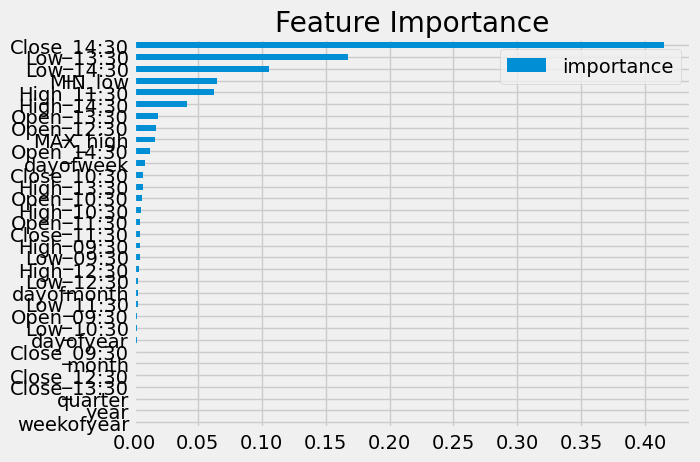

In [92]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [93]:
test['prediction'] = reg.predict(X_test)

In [94]:
# Assuming 'df' is your DataFrame that now includes 'target_close_1530', 'prediction', and 'close_1430' columns
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

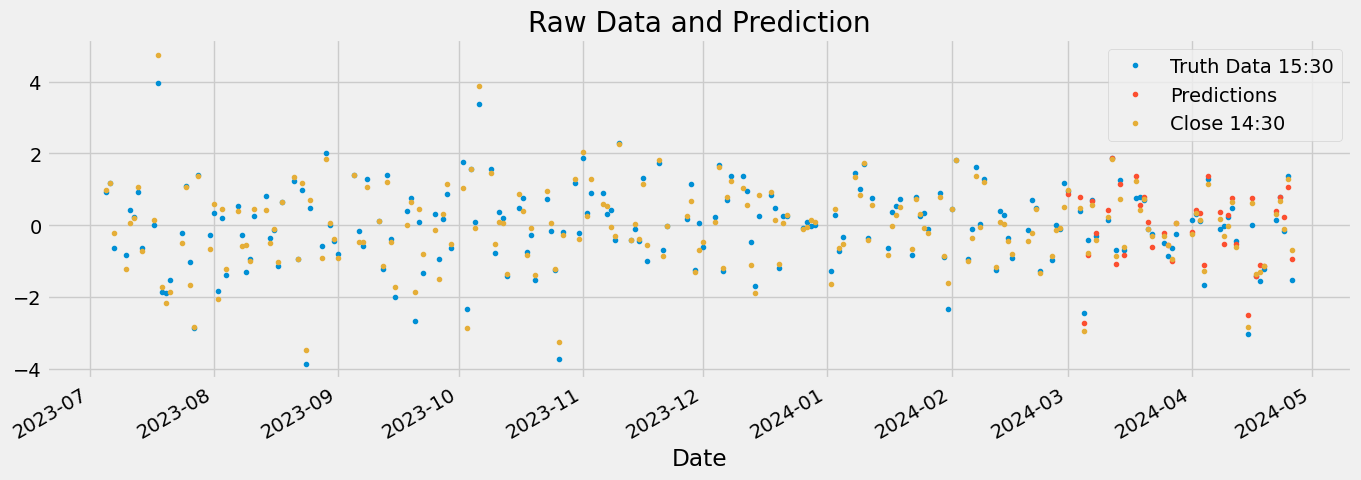

In [97]:

# Create a plot
fig, ax = plt.subplots(figsize=(15, 5))

# Plotting each series with different styles or markers if preferred
df['Close_target'].plot(ax=ax, style='.', label='Truth Data 15:30')  # Plot as dots
df['prediction'].plot(ax=ax, style='.', label='Predictions')  # Plot as dots
df['Close_14:30'].plot(ax=ax, style='.', label='Close 14:30')  # Plot as dots

# Add legend and title
plt.legend()
ax.set_title('Raw Data and Prediction')

# Show the plot
plt.show()


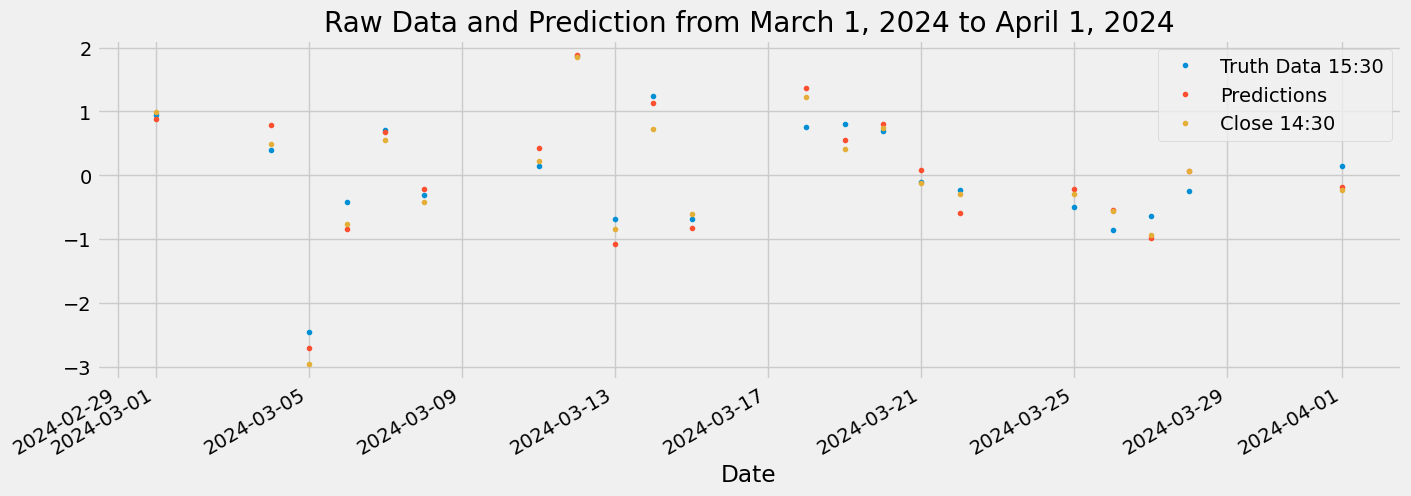

In [98]:

# Set the date range
start_date = '2024-03-01'
end_date = '2024-04-01'

# Assuming 'df' is your DataFrame that now includes 'target_close_1530', 'prediction', and 'close_1430' columns
# Ensure the index is of datetime type, if not already
df.index = pd.to_datetime(df.index)

# Filter the DataFrame to include only the data between the specified dates
filtered_df = df.loc[start_date:end_date]

# Create a plot
fig, ax = plt.subplots(figsize=(15, 5))

# Plotting each series with dots for this specific date range
filtered_df['Close_target'].plot(ax=ax, style='.', label='Truth Data 15:30')  # Plot as dots
filtered_df['prediction'].plot(ax=ax, style='.', label='Predictions')  # Plot as dots
filtered_df['Close_14:30'].plot(ax=ax, style='.', label='Close 14:30')  # Plot as dots

# Add legend and title
plt.legend()
ax.set_title('Raw Data and Prediction from March 1, 2024 to April 1, 2024')

# Show the plot
plt.show()


In [99]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate MAE
mae = mean_absolute_error(y_test, test['prediction'])
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate MSE
mse = mean_squared_error(y_test, test['prediction'])
print(f"Mean Squared Error (MSE): {mse}")

# Calculate RMSE
rmse = np.sqrt(mse)  # sqrt of MSE
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 0.2742305158259997
Mean Squared Error (MSE): 0.10999731861980529
Root Mean Squared Error (RMSE): 0.33165843667816636
